In [274]:
import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"

import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
%matplotlib inline

homedir=os.getenv("HOME")

dat_path = homedir+'/Desktop/wisesize/'

In [2]:
wisetab = Table.read(dat_path+'a100-nsa-for-adap.fits')

### First task -- Reproduce Galaxy Selection from Proposal
#### 0.002<z<0.025, SNR(NUV) or SNR(W3)>20, r-band R$_e$ > 5.5" (will instead use 6.5")

In [3]:
#define W3 and GALEX (NUV) SNR:
w3_flux = wisetab['w3_nanomaggies']
w3_ivar = wisetab['w3_nanomaggies_ivar']     #1/sig^2
w3_snr = w3_flux * np.sqrt(w3_ivar)
w3_snr_col = wisetab['W3SNR']

galex_flux = wisetab['NMGY'][:,1]   #supposedly corresponds to NUV flux in nanomaggies (nmgy)
galex_ivar = wisetab['NMGY_IVAR'][:,1] 
NUV_snr = galex_flux * np.sqrt(galex_ivar)

In [4]:
#SNR>20. cut
snr_flag = ((w3_snr>20.) | (w3_snr_col>20.)) | (NUV_snr>20.)
snr_flag10 = ((w3_snr>10.) | (w3_snr_col>10.)) | (NUV_snr>10.)

In [6]:
#redshift 0.002<z<0.025 cut
zmin=0.002
zmax=0.025

z = wisetab['ZDIST']
vhelio = wisetab['Vhelio']
z_flag = (z>zmin) & (z<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = z_flag | vhelioflag   #use both as a "check"

In [8]:
#r-band Re > 6.5" cut   (change to 5.5" to exactly replicate proposal values)
re_1 = wisetab['SERSIC_TH50']
re_2 = wisetab['petroR50_r']
re_flag = (re_1>6.5) | (re_2>6.5)
re_flag_55 = (re_1>5.5) | (re_2>5.5)

#### Generating Flag Table

In [9]:
zflag & re_flag & snr_flag
wise_flagtab = Table([wisetab['IAUNAME'],wisetab['RA'],wisetab['DEC'],zflag,snr_flag,
                      snr_flag10,re_flag,re_flag_55],
                     names=['IAUNAME','RA','DEC','zflag','snrflag_20',
                            'snrflag_10','re_flag65','re_flag55'])

In [59]:
wise_flagtab.write(homedir+'/Desktop/wisesize/WISESize_flags_v1.fits',overwrite=True)

#### RA v. DEC

In [10]:
proposal_sample = wisetab[zflag & re_flag & snr_flag]

In [11]:
ra = proposal_sample['RA']
dec = proposal_sample['DEC']
z = proposal_sample['ZDIST']

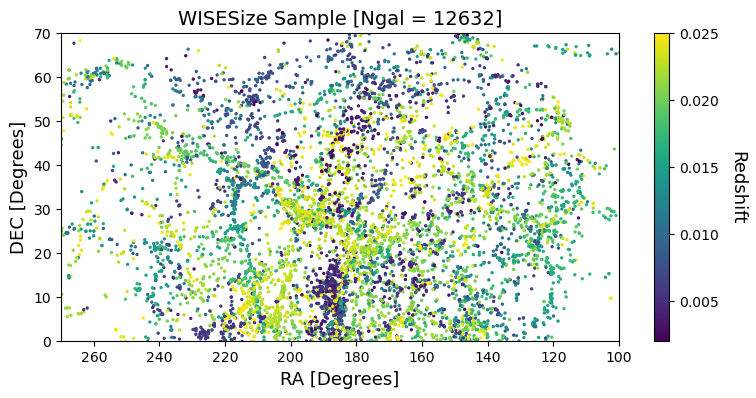

In [12]:
plt.figure(figsize=(9,4))
plt.scatter(ra,dec,c=z,s=2)
plt.xlim(270,100)
plt.ylim(0,70)
plt.clim(0.002,0.025)
cbar = plt.colorbar()
cbar.set_label('Redshift',fontsize=13,rotation=270,labelpad=20)
plt.xlabel('RA [Degrees]',fontsize=13)
plt.ylabel('DEC [Degrees]',fontsize=13)
plt.title(f'WISESize Sample [Ngal = {len(proposal_sample)}]',fontsize=14)
plt.show()

---

### NED-LVS 

In [232]:
#full NED-LVS sample (includes RA, DEC, redshifts, ...)
ned_sample = Table.read(homedir+'/Desktop/wisesize/NEDLVS_20210922_v2.fits')

#nedbyname --> contains row indices nedbyname["ROW"]
#nedgeometry --> GALAXY, MAG, MAG_REF, DIAM (in arcminutes!), DIAM_REF, BA, BA_REF, PA, PA_REF
nedgeometry = Table.read(homedir+'/Desktop/NEDgeometry-NEDLVS_20210922_v2.fits')
nedbyname = Table.read(homedir+'/Desktop/NEDbyname-NEDLVS_20210922_v2.fits')

In [233]:
#I need diameters, so I will row-match the ned_sample to follow the indexing of the
#nedgeometry and nedbyname tables. the latter two tables are, in fact, missing 135 
#(or so?) galaxies.

ned_sample = ned_sample[nedbyname['ROW']]

In [234]:
#apply the sample cuts...

redshift_flag = (ned_sample['z']>0.002) & (ned_sample['z']<0.025)
ra_flag = (ned_sample['ra']>100.) & (ned_sample['ra']<270.)
dec_flag = (ned_sample['z']>0.) & (ned_sample['z']<70.)

#remove g_pair (galaxy pair) and g_trip objtypes
g_flag = (ned_sample['objtype']=='GPair') | (ned_sample['objtype']=='GTrpl')

In [235]:
#note that 50503 is the number if we do not trim according to the nedbyname indices

#ned_sample = ned_sample[g_flag]
#nedgeometry = nedgeometry[g_flag]
#nedbyname = nedbyname[g_flag]

cut_ned_sample = ned_sample[redshift_flag&ra_flag&dec_flag&~g_flag]
print(len(cut_ned_sample))

49301


In [116]:
#np.unique(cut_ned_sample['objtype'])

#### Comparing with z0MGS and SGA-2020 (pre-nedgeometry, during which we needed size sources that are now available via...nedgeometry. :-) )

Using TOPCAT, I then compared this table with the full z0MGS. Using RA, DEC and a max error of 2", I found 8002 matches in the case where GPair galaxies are retained and 7997 matches when GPair galaxies are removed.

In [ ]:
lvs_z0mgs = Table.read(homedir+'/Desktop/wisesize/z0mgs_LVS_matches_nogpair.fits')

Create z0mgs flag for LVS galaxies:

In [149]:
objname_matches = []
for obj in lvs_z0mgs['objname']:
    objname_matches.append(obj.strip())

In [150]:
z0mgs_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        z0mgs_match_flag[i] = True
    else:
        z0mgs_match_flag[i] = False

In [151]:
len(cut_ned_sample[z0mgs_match_flag])

7997

In [154]:
#cut_ned_sample[~z0mgs_match_flag].write(homedir+'/Desktop/wisesize/LVS_sample_noz0MGS_nogpair.fits')

Of the galaxies with no z0mgs matches, when compared with SGA-2020 I found 15257 matches (again used RA, DEC with a max error of 2") if gpairs are retained and 15238 matches if removed.

In [155]:
lvs_sga = Table.read(homedir+'/Desktop/wisesize/SGA2020_LVS_matches_nogpair.fits')

In [156]:
objname_matches = []
for obj in lvs_sga['objname']:
    objname_matches.append(obj.strip())

In [157]:
sga2020_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        sga2020_match_flag[i] = True
    else:
        sga2020_match_flag[i] = False

In [158]:
len(cut_ned_sample[sga2020_match_flag])

15238

In [159]:
print(f'Number of galaxies unspoken for: {len(cut_ned_sample[~sga2020_match_flag & ~z0mgs_match_flag])}')

Number of galaxies unspoken for: 26796


---

#### Evaluating NED-LVS diameters

In [236]:
#note again that these values are in ARCMINUTES
diam_full = nedgeometry['DIAM']

#flag to remove what I assume to be error diameters
err_flag = (diam_full<0.)

diam_cut = diam_full[redshift_flag&ra_flag&dec_flag&~g_flag&~err_flag]
diam_full = diam_full[~err_flag]

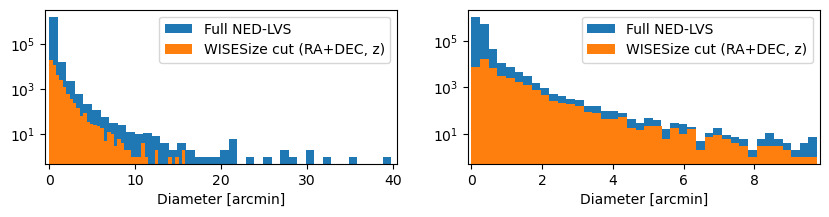

In [252]:
fig, ax = plt.subplots(1,2,figsize=(10,2))
ax1,ax2 = ax.flatten()

ax1.hist(diam_full[diam_full<40.],bins=40,label='Full NED-LVS')
ax1.hist(diam_cut[diam_cut<40.],bins=40,label='WISESize cut (RA+DEC, z)')
ax1.set_xlim(-0.5,40.5)
ax1.set_yscale('log')
ax1.set_xlabel('Diameter [arcmin]',fontsize=10)
ax1.legend()

ax2.hist(diam_full[diam_full<10.],bins=40,label='Full NED-LVS')
ax2.hist(diam_cut[diam_cut<10.],bins=40,label='WISESize cut (RA+DEC, z)')
ax2.set_xlim(-0.1,9.85)
ax2.set_yscale('log')
ax2.set_xlabel('Diameter [arcmin]',fontsize=10)
ax2.legend()

plt.show()

#### Comparing NED-LVS SFR, Mstar values with CIGALE results for VFS

In [344]:
#I will provide two comparisons --> one with galaxy negative fluxes excluded, and one included.
#note that I apply a 5% minimum error floor all fluxes in both cases.

#this table has VFID, NEDname (which I can compare with objname_2 of the same table), 
#SFR_W4, SFR_hybrid, Mstar
matched_tab = Table.read(dat_path+'VFS_NED_match.fits')

#all results from CIGALE run on VFS, with no negative flux vals
north=Table.read(homedir+'/Desktop/cigale_runs/cigale_vf_north_oct2024/out/results.fits')
south=Table.read(homedir+'/Desktop/cigale_runs/cigale_vf_south_oct2024/out/results.fits')
cigale_tab = vstack([north,south])

#all results from CIGALE run on VFS, *with* flux values >-5.
cigale_tab_neg = Table.read(homedir+'/Desktop/cigale_vf/results_NS_5err_neg.fits')

In [345]:
#quickly define a function which generates a flag to ensure the catalogs are correctly comparable
def get_flags(cat1_VFID,cat2_VFID):
    flag1=[]
    flag2=[]
    for VFID in cat1_VFID:
        if VFID in cat2_VFID:
            flag1.append(True)
        else:
            flag1.append(False)
    for VFID in cat2_VFID:
        if VFID in cat1_VFID:
            flag2.append(True)
        else:
            flag2.append(False)
    return flag1, flag2

In [346]:
matched_VFID = matched_tab['VFID']
cigale_VFID = cigale_tab['id']   #has same VFID entries as negative version

In [347]:
#flags to ensure same VFIDs are in each array
flag_matched, flag_cigale = get_flags(matched_VFID, cigale_VFID)

In [348]:
#applying said flags
matched_tab = matched_tab[flag_matched]
cigale_tab = cigale_tab[flag_cigale]
cigale_tab_neg = cigale_tab_neg[flag_cigale]

In [349]:
matched_Mstar = np.log10(matched_tab['Mstar'])
matched_SFR = np.log10(matched_tab['SFR_W4'])

cigale_Mstar = np.log10(cigale_tab['bayes.stellar.m_star'])
cigale_SFR = np.log10(cigale_tab['bayes.sfh.sfr'])

cigale_neg_Mstar = np.log10(cigale_tab_neg['bayes.stellar.m_star'])
cigale_neg_SFR = np.log10(cigale_tab_neg['bayes.sfh.sfr'])

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_58928/3363446402.py:7: RuntimeWarning: invalid value encountered in log10
  cigale_neg_Mstar = np.log10(cigale_tab_neg['bayes.stellar.m_star'])
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_58928/3363446402.py:8: RuntimeWarning: invalid value encountered in log10
  cigale_neg_SFR = np.log10(cigale_tab_neg['bayes.sfh.sfr'])


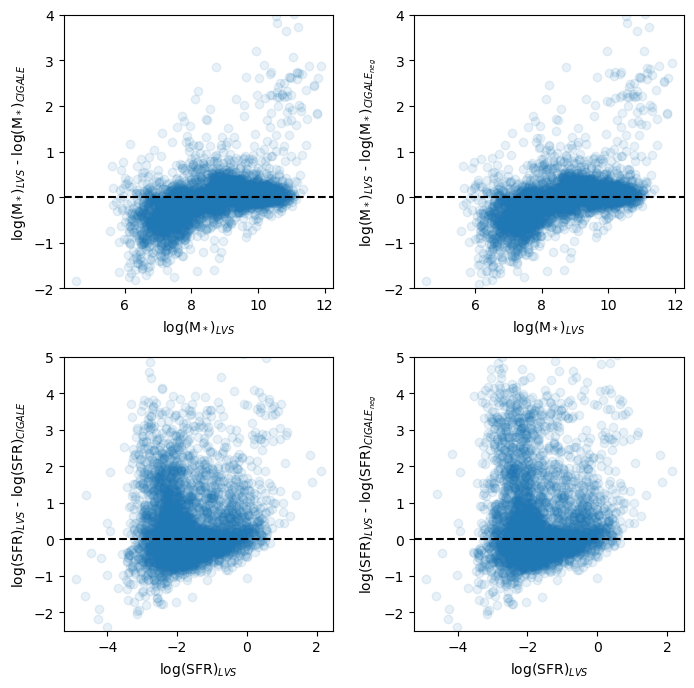

In [352]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
fig.subplots_adjust(wspace=0.3,hspace=0.25)
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.scatter(matched_Mstar,matched_Mstar-cigale_Mstar,alpha=0.1)
ax1.axhline(0,color='black',ls='--')
ax1.set_xlabel(r'log(M$_*$)$_{LVS}$',fontsize=10)
ax1.set_ylabel(r'log(M$_*$)$_{LVS}$ - log(M$_*$)$_{CIGALE}$',fontsize=10)
ax1.set_ylim(-2,4)

ax2.scatter(matched_Mstar,matched_Mstar-cigale_neg_Mstar,alpha=0.1)
ax2.axhline(0,color='black',ls='--')
ax2.set_xlabel(r'log(M$_*$)$_{LVS}$',fontsize=10)
ax2.set_ylabel(r'log(M$_*$)$_{LVS}$ - log(M$_*$)$_{CIGALE_{neg}}$',fontsize=10)
ax2.set_ylim(-2,4)

ax3.scatter(matched_SFR,matched_SFR-cigale_SFR,alpha=0.1)
ax3.axhline(0,color='black',ls='--')
ax3.set_xlabel(r'log(SFR)$_{LVS}$',fontsize=10)
ax3.set_ylabel(r'log(SFR)$_{LVS}$ - log(SFR)$_{CIGALE}$',fontsize=10)
ax3.set_ylim(-2.5,5)

ax4.scatter(matched_SFR,matched_SFR-cigale_neg_SFR,alpha=0.1)
ax4.axhline(0,color='black',ls='--')
ax4.set_xlabel(r'log(SFR)$_{LVS}$',fontsize=10)
ax4.set_ylabel(r'log(SFR)$_{LVS}$ - log(SFR)$_{CIGALE_{neg}}$',fontsize=10)
ax4.set_ylim(-2.5,5)

plt.show()

----

#### Misc. code to take VFS+NED table, the union of which being courtesy of TOPCAT, and add a row-matched VFS membership flag to the NED-LVS table.

In [ ]:
match = Table.read(homedir+'/Desktop/wisesize/VFS_NED_match.fits')
obj=match['objname_2']
for i in range(len(obj)):
    obj[i] = obj[i].strip()
VFS_flag = []
for i in ned_sample['objname']:
    if i.strip() in obj:
        VFS_flag.append(True)
    else:
        VFS_flag.append(False)
ned_sample['VFS_flag'] = VFS_flag
ned_sample.write(homedir+'/Desktop/wisesize/NEDLVS_20210922_v2.fits',overwrite=True)